# Crypto-Cosmology, Part 1: Wormhole

## Context
Bla bla
### Wormhole

https://twitter.com/wormholecrypto/status/1450540170348949504

### Terra Bridge


### Objective

As Wormhole has added Terra support with the Columbus 5 upgrade, analyze the initial activity: 
* How many users are engaging, what tokens are they receiving vs sending? 
* Which destinations/sources are most popular? 
* What is the adoption rate, i.e. how rapidly are users choosing to use Wormhole over the Terra-specific Bridge? 
* Anything else you observe of interest?


## Data

### Query
The query used to retrieve the relevant data can be found [here](https://app.flipsidecrypto.com/velocity/queries/5027ee2e-4de7-41dd-8686-072046b3ce8b). Some main points to highlight:
* 
* 
* 

### Structure

## Notebook structure
* 
* 
* 

## Key Findings
* 
* 
* 

**Wormhole Send**

``` sql
    select
    *,
  	msg_value:sender,
  	msg_value:execute_msg:initiate_transfer:recipient_chain, 
  	msg_value:execute_msg:initiate_transfer:asset:amount,
  	msg_value:execute_msg:initiate_transfer:asset:info:native_token:denom,
  	msg_value:execute_msg:initiate_transfer:asset:info:token:contract_addr
    from terra.msgs
    where msg_value:contract = 'terra10nmmwe8r3g99a9newtqa7a75xfgs2e8z87r2sf'
      and msg_value:execute_msg:initiate_transfer is not null
```

**Wormhole - Receieve UST/Luna**
``` sql
 select 
  block_timestamp,
  tx_id,
  event_attributes:"1_amount"[0]:amount amount,
  event_attributes:"1_amount"[0]:denom denom,
  event_attributes:"1_recipient" recipient,
  event_attributes:"1_sender" sender,
  event_attributes:"0_sender" original_sender,
  *
from terra.msg_events
where event_attributes:"1_sender" = 'terra10nmmwe8r3g99a9newtqa7a75xfgs2e8z87r2sf'
and event_type = 'transfer'
```

**Wormhole - Receieve Wrapped Tokens**
``` sql
select 
  block_timestamp,
  tx_id,
  event_attributes:"0_amount" amount,
  event_attributes:"1_contract_address" token_address,
  event_attributes:"recipient" recipient,
  *
from terra.msg_events
where 
event_attributes:"0_contract_address" = 'terra10nmmwe8r3g99a9newtqa7a75xfgs2e8z87r2sf'
and event_attributes:"0_action" in ('complete_transfer_wrapped')
and event_type = 'from_contract'
```

**Terra Bridge - Send**

``` sql
    select 
  	block_timestamp, 
  	tx_id, 
  	msg_value:to_address to_address, 
  	msg_value:from_address from_address, 
  	msg_value:amount[0]:amount amount,
  	msg_value:amount[0]:denom denom,
  	   array_size(msg_value:amount), msg_value,
  	   case
  		when msg_value:to_address in ('terra1g6llg3zed35nd3mh9zx6n64tfw3z67w2c48tn2', 'terra13yxhrk08qvdf5zdc9ss5mwsg5sf7zva9xrgwgc', 'terra1rtn03a9l3qsc0a9verxwj00afs93mlm0yr7chk') then 'SEND'
  	  	else ''
  	   end type_op
from terra.msgs
where msg_value:to_address in ('terra1g6llg3zed35nd3mh9zx6n64tfw3z67w2c48tn2', 'terra13yxhrk08qvdf5zdc9ss5mwsg5sf7zva9xrgwgc', 'terra1rtn03a9l3qsc0a9verxwj00afs93mlm0yr7chk')

```

**Terra Bridge - Receieve**
``` sql
 select 
  	block_timestamp, 
  	tx_id, 
  	msg_value:to_address to_address, 
  	msg_value:from_address from_address, 
  	msg_value:amount[0]:amount amount,
  	msg_value:amount[0]:denom denom,
  	array_size(msg_value:amount), msg_value,
  	case
  		when msg_value:from_address ('terra1g6llg3zed35nd3mh9zx6n64tfw3z67w2c48tn2', 'terra13yxhrk08qvdf5zdc9ss5mwsg5sf7zva9xrgwgc', 'terra1rtn03a9l3qsc0a9verxwj00afs93mlm0yr7chk') then 'RECEIVE'
 		else ''
  	end type_op
from terra.msgs
where 
  	  msg_value:from_address in ('terra13yxhrk08qvdf5zdc9ss5mwsg5sf7zva9xrgwgc', 'terra13yxhrk08qvdf5zdc9ss5mwsg5sf7zva9xrgwgc', 'terra1rtn03a9l3qsc0a9verxwj00afs93mlm0yr7chk')
```

# Analysis

## Transactions
* Number of total transactions
* Number of daily transactions over time

In [111]:
wh_receive_.tx_id.count() + wh_send.tx_id.count()

5906

<AxesSubplot:xlabel='Day', ylabel='Number of daily transactions'>

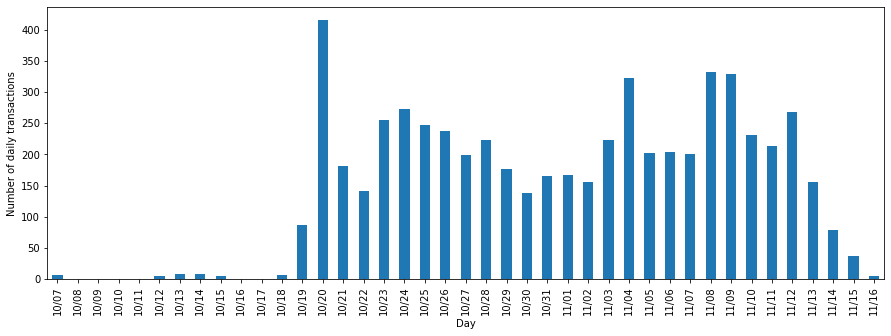

In [112]:
tot_daily_txs = wh_send[['month_day', 'tx_id']].append(wh_receive_[['month_day', 'tx_id']])
daily_tx = add_missing_days(tot_daily_txs.groupby("month_day").tx_id.count())
ax = daily_tx.plot(kind='bar')
ax.set(ylabel='Number of daily transactions', xlabel='Day')
ax

In [113]:
daily_tx.mean()

144.0487804878049

In [114]:
daily_tx[daily_tx.index > '10/18'].mean()

202.3448275862069

**Observations**
* 
* 

## Distinct address
* Number of distinct users sending or receiving in total. What about over time? Any increase?

In [115]:
tot_unique_addr = wh_send[['month_day', 'sender']].append(wh_receive_[['month_day', 'sender']])
len(tot_unique_addr.sender.unique())

1956

In [116]:
daily_unique_addresses = add_missing_days(tot_unique_addr.groupby("month_day").sender.nunique())

[]

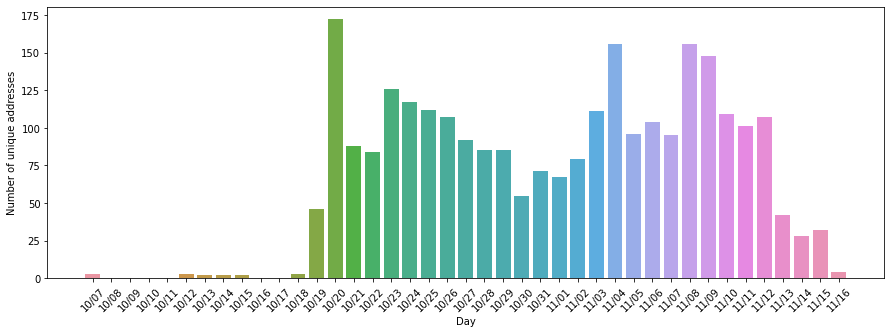

In [117]:
plt.xticks(rotation=45)
ax = sns.barplot(daily_unique_addresses.index, daily_unique_addresses.values)
ax.set(ylabel='Number of unique addresses', xlabel='Day')
ax.plot()

In [118]:
daily_unique_addresses.mean()

65.60975609756098

In [119]:
daily_unique_addresses[daily_unique_addresses.index > '10/18'].mean()

92.24137931034483

**Observations**
* 
* 

## Tokens
* What tokens have been sent/received?
* What tokens are most popular?

In [120]:
token_txs = pd.concat([wh_receive_.token_name.value_counts(), wh_send.token_name.value_counts()], axis=1).fillna(0)

In [121]:
token_amounts = pd.concat([wh_receive_.groupby("token_name").amount.sum(), wh_send.groupby("token_name").amount.sum()], axis=1).fillna(0)

In [122]:
wh_receive_.token_name.append(wh_send.token_name).unique()

array(['uluna', 'uusd', 'ORION_Terra', 'whORION_BSC', 'wh_Solana',
       'whUSDT_BSC', 'whWETH_Ethereum', 'whWBNB_BSC', 'whSOL_Solana',
       'whUSDT_Ethereum', '', 'whUST_Polygon', 'whLUNA_Polygon',
       'whWBTC_Ethereum', 'whATOM_BSC', 'whUSDC_Polygon', 'whETH_Solana',
       'whMIR_BSC', 'whUSDT_Polygon', 'MINE_Terra', 'MIR_Terra',
       'ANC_Terra'], dtype=object)

[Text(0, 0.5, 'Number of transactions'), Text(0.5, 0, 'Asset transferred')]

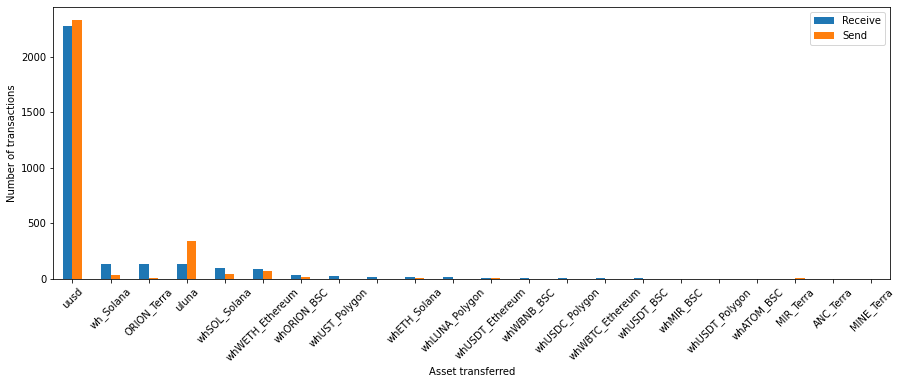

In [123]:
token_txs.columns = ['Receive','Send']
ax = token_txs.plot(kind='bar', rot=45)
ax.set(ylabel='Number of transactions', xlabel='Asset transferred')

[Text(0, 0.5, 'Total amount transferred'), Text(0.5, 0, 'Asset')]

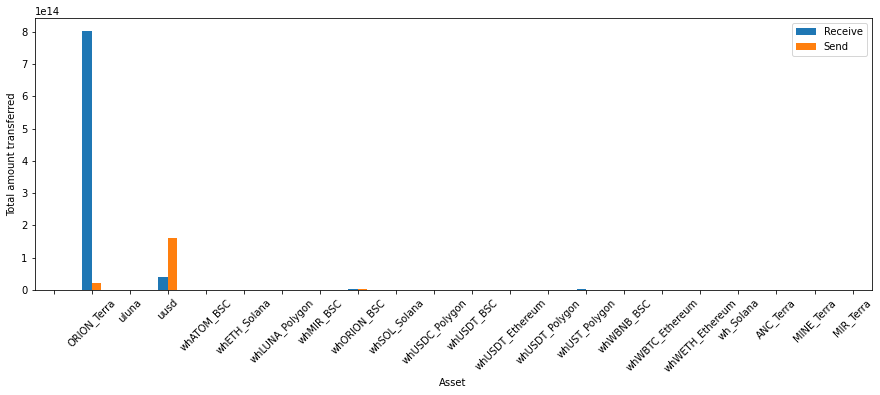

In [124]:
token_amounts.columns = ['Receive','Send']
ax = token_amounts.plot(kind='bar', rot=45)
ax.set(ylabel='Total amount transferred', xlabel='Asset')

In [125]:
wh_receive_.sort_values(by="amount", ascending=False).head()

,amount,block_timestamp,recipient,original_sender,sender,tx_id,token_name,month_day,year_month_day
411,406000000000000,2021-11-02 20:40:03+00:00,"""terra1w5l9ggryqy8q49pyfl9gqrfwdugynmd09xvwlk""","""terra1w5l9ggryqy8q49pyfl9gqrfwdugynmd09xvwlk""","""terra1w5l9ggryqy8q49pyfl9gqrfwdugynmd09xvwlk""",1060A41659F5B72523815A0AD888AF69FA729EF722D06239400C2D8A80A48798,ORION_Terra,11/02,b.year/11/02
565,214286000000000,2021-11-15 14:19:12+00:00,"""terra1w5l9ggryqy8q49pyfl9gqrfwdugynmd09xvwlk""","""terra1w5l9ggryqy8q49pyfl9gqrfwdugynmd09xvwlk""","""terra1w5l9ggryqy8q49pyfl9gqrfwdugynmd09xvwlk""",78519BD163D14E51458087B27AB2198DC95A04C0762E77660AB30A1E65E92B4F,ORION_Terra,11/15,b.year/11/15
150,14285714285714,2021-11-09 00:45:20+00:00,"""terra15ly4zprkshh73k59g6ssdf3027zl6nd59rljpe""","""terra15ly4zprkshh73k59g6ssdf3027zl6nd59rljpe""","""terra15ly4zprkshh73k59g6ssdf3027zl6nd59rljpe""",9BC236FB9B447BCC445BC4E2DFCE9826AC2A577FADBD4F00527DE7CC7C81165B,ORION_Terra,11/09,b.year/11/09
389,13356283590000,2021-11-09 14:37:01+00:00,"""terra12chw9xgz3wg6q50vtqru932n095pyt4lwxg97c""","""terra12chw9xgz3wg6q50vtqru932n095pyt4lwxg97c""","""terra12chw9xgz3wg6q50vtqru932n095pyt4lwxg97c""",5A0888B65EE2815AAB30467A833597FD1C27B6AE86418EB879871EC46B3398A3,ORION_Terra,11/09,b.year/11/09
32,9946383000000,2021-11-14 21:27:14+00:00,"""terra18dhzhvr76z0n668gcx242p35z7wuyd8xt0aq4t""","""terra18dhzhvr76z0n668gcx242p35z7wuyd8xt0aq4t""","""terra18dhzhvr76z0n668gcx242p35z7wuyd8xt0aq4t""",68C7284239F59499F17E16BA75D5CD57F75A6939548580CD8B15B79DC6DCB2AC,ORION_Terra,11/14,b.year/11/14


[Text(0, 0.5, 'Total of amount transferred'), Text(0.5, 0, 'Asset')]

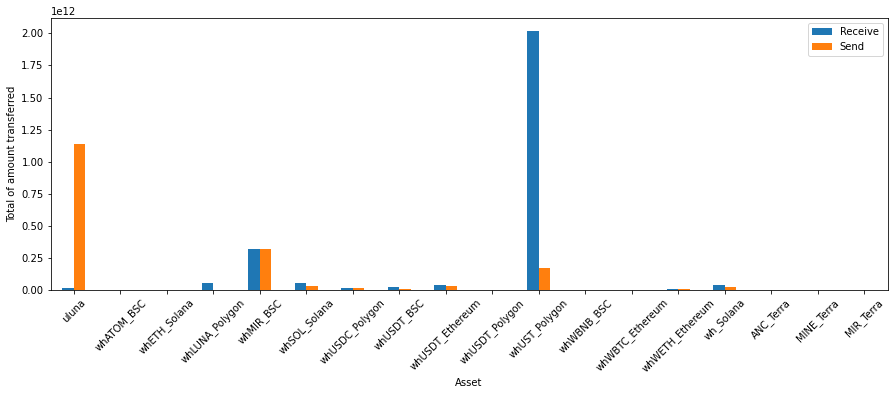

In [126]:
ax = token_amounts[(token_amounts.index != 'whORION_BSC')& (token_amounts.index != 'ORION_Terra') & (token_amounts.index != '')\
                       & (token_amounts.index != 'uusd')].plot(kind='bar', rot=45)
ax.set(ylabel='Total of amount transferred', xlabel='Asset')

**Observations**
* 
* 

## UST transactions
* Average amount of ust sent/received per day

In [127]:
wh_receive_ust = wh_receive_[wh_receive_.token_name == 'uusd']
wh_send_ust = wh_send[wh_send.token_name == 'uusd']

In [128]:
f"{wh_send_ust.amount.sum()/1000000/1000000} millions"

'161.614850616342 millions'

In [129]:
f"{wh_receive_ust.amount.sum()/1000000/1000000} millions"

'40.832040751038 millions'

In [130]:
(wh_send_ust.amount/1000000).describe().apply(lambda x: format(x, 'f'))

count        2328.000000
mean        69422.186691
std       1261317.712765
min             0.000001
25%            20.000000
50%           410.000000
75%          3135.000000
max      41999990.000000
Name: amount, dtype: object

In [131]:
wh_receive_ust[wh_receive_ust.amount < (wh_receive_ust.amount/1000000).quantile([.90]).iloc[0]].amount.mean()

5818.4324324324325

In [132]:
wh_send_ust[wh_send_ust.amount < (wh_send_ust.amount/1000000).quantile([.90]).iloc[0]].amount.mean()

7779.0

**Observations**
* 
* 

## Chains
* Transaction per chain, and overtime
* Any increase in usage for some chains? What about ratio wise on all txs

In [133]:
tot_unique_addr = wh_send[['month_day', 'sender']].append(wh_receive_[['month_day', 'sender']])

In [134]:
wh_send["recipient_chain_name"]=wh_send.recipient_chain.apply(lambda x: chain_ids[x-1])

[Text(0, 0.5, 'Number of transactions'), Text(0.5, 0, 'Destination chain')]

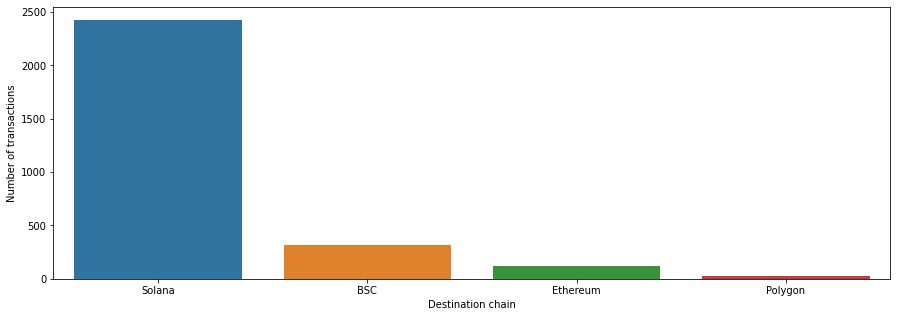

In [135]:
df = wh_send.recipient_chain_name.value_counts()
ax = sns.barplot(df.index,df.values)
ax.set(ylabel='Number of transactions', xlabel='Destination chain')

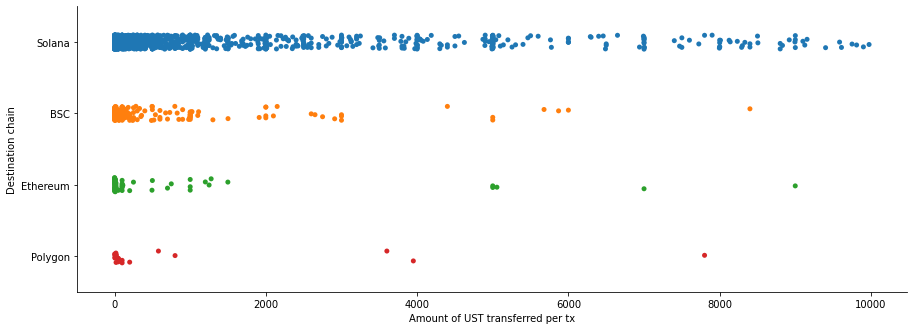

In [136]:
df = wh_send[(wh_send.denom=='uusd')&(wh_send.amount<10000000000)]
df.amount = df.amount/1000000
ax = sns.catplot(y="recipient_chain_name", x="amount", data=df, height=4.5, aspect=2.8)
ax.set(ylabel='Destination chain', xlabel='Amount of UST transferred per tx')

[Text(0, 0.5, 'Number of Wormhole daily transactions'), Text(0.5, 0, 'Day')]

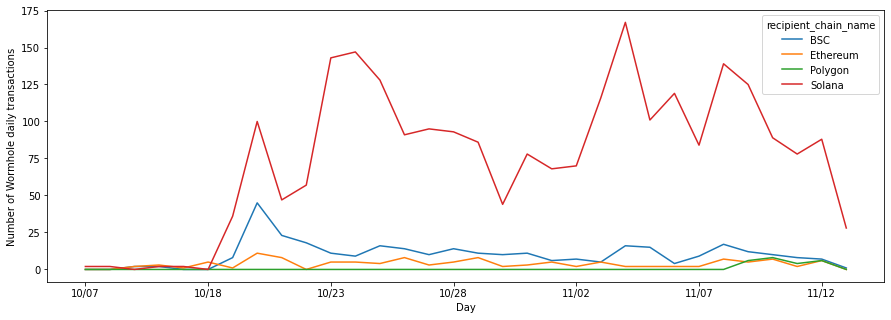

In [137]:
ax = wh_send.groupby(["recipient_chain_name","month_day"]).count().reset_index()\
    .pivot(index='month_day', columns='recipient_chain_name', values='tx_id')\
    .fillna(0)\
    .reset_index()\
    .set_index("month_day").plot(kind="line")
ax.set(ylabel='Number of Wormhole daily transactions', xlabel='Day')

**Observations**
* 
* 

## Most active addresses

In [138]:
fields = ['block_timestamp', 'address', 'amount', 'token_name']
wh_send.rename(columns={'sender':'address'}, inplace=True)
wh_receive_['address'] = wh_receive.apply(lambda row: row.recipient if row.original_sender == 'terra10nmmwe8r3g99a9newtqa7a75xfgs2e8z87r2sf'\
                     else row.original_sender, axis=1)
token_addr = wh_receive_[fields].append(wh_send[fields])

[]

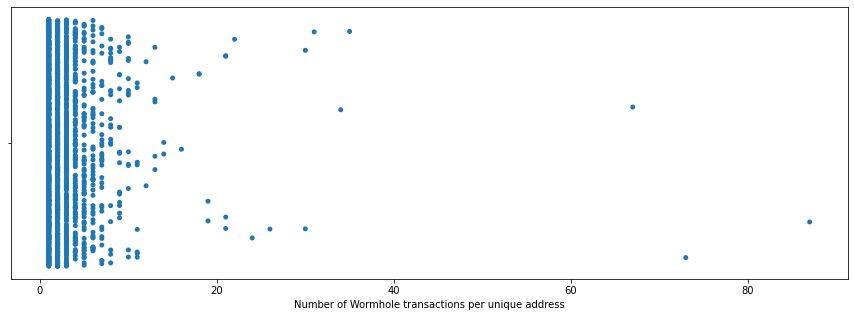

In [139]:
ax = sns.stripplot(token_addr.address.value_counts())
ax.set(xlabel='Number of Wormhole transactions per unique address')
ax.plot()

In [140]:
token_addr.address.value_counts().describe()

count    2249.000000
mean        2.626056
std         3.842571
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        87.000000
Name: address, dtype: float64

In [141]:
token_addr.address.value_counts().quantile([0.9,0.99])

0.90     5.00
0.99    13.52
Name: address, dtype: float64

**Observations**
* 
* 

## Usage comparison with Terra Bridge

In [142]:
tb_all.type_op.value_counts()

RECEIVE    250644
SEND        98785
Name: type_op, dtype: int64

In [143]:
tb_all.chain.value_counts()

BSC         264557
Ethereum     70018
Harmony      14854
Name: chain, dtype: int64

<AxesSubplot:xlabel='Day', ylabel='Number of Terra Bridge daily transactions'>

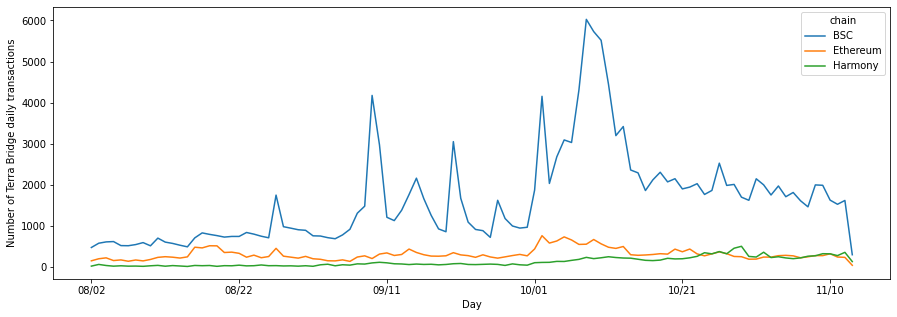

In [144]:
ax = tb_all[tb_all.year_month_day > '2021/08/01'].groupby(["chain","month_day"]).count().reset_index()\
    .pivot(index='month_day', columns='chain', values='tx_id')\
    .fillna(0)\
    .reset_index()\
    .set_index("month_day").plot(kind="line")
ax.set(ylabel='Number of Terra Bridge daily transactions', xlabel='Day')
ax

In [145]:
chains_to_compare = ['BSC','Ethereum', 'Harmony']

<AxesSubplot:xlabel='Day', ylabel='Number of Terra Bridge daily transactions'>

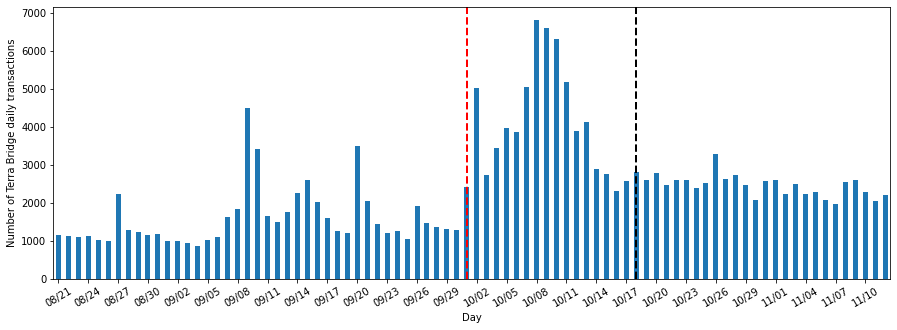

In [146]:
df = tb_all[(tb_all.year_month_day > '2021/08/20')&(tb_all.chain.isin(chains_to_compare))]\
    .groupby("month_day").count().tx_id.sort_index()[:-1]
ax = df.plot(kind='bar', rot=30)
ax.axvline(ymin=0, x=41, ymax=600, color='r', linestyle='--', lw=2)
ax.axvline(ymin=0, x=58, ymax=600, color='black', linestyle='--', lw=2)
ax.set_xticks([i for i in range(len(df.index))][0::3])
ax.set(ylabel='Number of Terra Bridge daily transactions', xlabel='Day')
ax

In [147]:
tb_all[(tb_all.month_day >= '10/18')&(tb_all.month_day < '10/25')&(tb_all.chain.isin(chains_to_compare))]\
    .groupby("month_day").count().tx_id.describe()

count       7.000000
mean     2612.000000
std       149.240298
min      2391.000000
25%      2540.500000
50%      2611.000000
75%      2699.000000
max      2803.000000
Name: tx_id, dtype: float64

In [148]:
tb_all[(tb_all.month_day >= '11/05')&(tb_all.month_day < '11/12')&(tb_all.chain.isin(chains_to_compare))]\
    .groupby("month_day").count().tx_id.describe()

count       7.000000
mean     2259.714286
std       244.479525
min      1982.000000
25%      2058.500000
50%      2276.000000
75%      2424.000000
max      2595.000000
Name: tx_id, dtype: float64

In [149]:
before_wh = tb_all[(tb_all.year_month_day > '2021/09/01')&(tb_all.month_day < '10/18')&\
            (tb_all.chain.isin(chains_to_compare))]\
    .groupby("month_day").count().tx_id
linregress([i for i in range(len(before_wh.values))],before_wh.values)

LinregressResult(slope=68.93610854147394, intercept=1057.6549491211842, rvalue=0.5746650241897068, pvalue=2.9586813536862243e-05, stderr=14.800122123268254)

In [150]:
after_wh = tb_all[(tb_all.year_month_day >= '2021/10/18')&(tb_all.chain.isin(chains_to_compare))]\
    .groupby("month_day").count().tx_id[:-1]
linregress([i for i in range(len(after_wh.values))],after_wh.values)

LinregressResult(slope=-22.161025641025642, intercept=2744.589743589743, rvalue=-0.5902270694989652, pvalue=0.0015034669532172037, stderr=6.186803400289089)

[]

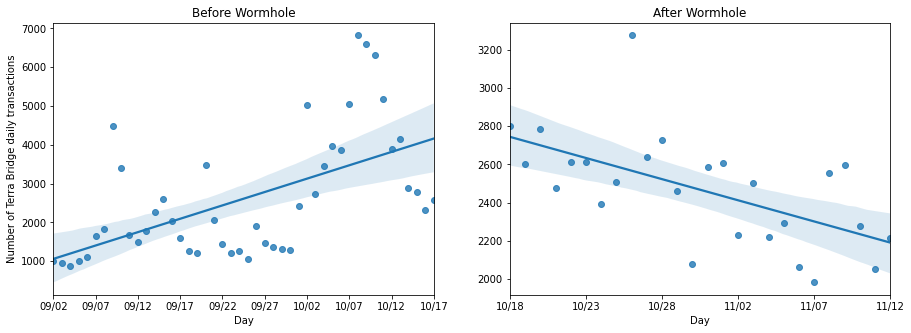

In [151]:
fig, axes = plt.subplots(nrows=1, ncols=2)
ax = sns.regplot([i for i in range(len(before_wh.values))],before_wh.values, ax=axes[0])
xticks = []
for i in range(len(before_wh.index)):
    if(i%round(len(before_wh.index)/10)==0):
        xticks.append(before_wh.index[i])
ax.set_xticklabels(xticks)
ax.set(ylabel='Number of Terra Bridge daily transactions', xlabel='Day')
ax.set_title("Before Wormhole")
ax = sns.regplot([i for i in range(len(after_wh.values))],after_wh.values,ax=axes[1])
xticks = []
for i in range(len(after_wh.index)):
    if(i%math.ceil(len(after_wh.index)/6)==0):
        xticks.append(after_wh.index[i])
ax.set_xticklabels(xticks)
ax.set(xlabel='Day')
ax.set_title("After Wormhole")
ax.plot()

**Observations**
* 
* 

## Conversion Ratio

In [186]:
chains_to_compare = ['BSC','Ethereum', 'Harmony', 'Solana', 'Polygon']

In [187]:
tb_chain_address = tb_all[tb_all.chain.isin(chains_to_compare)].apply(lambda row: \
                        row.from_address if row.to_address == 'terra1g6llg3zed35nd3mh9zx6n64tfw3z67w2c48tn2'\
                                     else row.from_address, axis=1)

both_bridges_address = set(wh_receive_.address.append(wh_send.address).values).intersection(tb_all['address'].values)

In [198]:
wh_chains_all = wh_receive_.append(wh_send[wh_send.recipient_chain_name.isin(chains_to_compare)])
both_bridges_address = set(wh_chains_all.address.values)\
                           .intersection(tb_all['address'].values)

In [199]:
len(both_bridges_address)

852

In [200]:
f"{'{:.2f}'.format(len(both_bridges_address)/len(set(tb_chain_address.values))*100)}% of all address using TB have used Wormhole"

'3.32% of all address using TB have used Wormhole'

<AxesSubplot:>

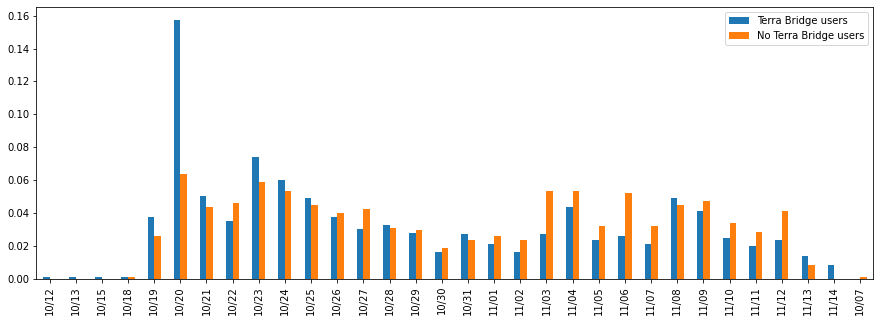

In [277]:
#ax = plt.gca()
df_1 = wh_chains_all[wh_chains_all.address.isin(both_bridges_address)]\
            .groupby('address').month_day.min().value_counts().sort_index().rename('Terra Bridge users')
df_1 = df_1/len(both_bridges_address)
df3 = wh_all[~wh_all.address.isin(both_bridges_address)]
df_2 = df3.groupby('address').month_day.min().value_counts().sort_index().rename('No Terra Bridge users')
df_2 = df_2/df3.address.nunique()
#.plot(kind='bar', ax=ax)
df_3 = pd.DataFrame([df_1,df_2]).transpose().fillna(0)
df_3.plot(kind='bar')

## Conclusions

**----------------------------------------------------------------------------------------------------**

# Appendix

## Data preparation

**Imports**

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import math
from scipy.stats import linregress
import warnings
import json
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
matplotlib.rcParams['figure.figsize'] = (15.0, 5.0)
pd.set_option('display.max_columns', 120)
pd.options.display.max_colwidth = 10000

### Chain IDs:
* 1 -> Solana
* 2 -> Ethereum
* 3 -> Terra
* 4 -> BSC
* 5 -> Polygon

In [2]:
chain_ids = ['Solana', 'Ethereum', 'Terra', 'BSC', 'Polygon']

In [3]:
#with open("./tokens.json", "w") as f:
    #f.write(json.dumps(tokens))
with open("./tokens.json", "r") as f:
    tokens = json.load(f)

In [4]:
url_wh_receive = 'https://api.flipsidecrypto.com/api/v2/queries/657279fb-8a07-4089-bf08-307fb7f1325d/data/latest'
url_wh_receive_tokens = 'https://api.flipsidecrypto.com/api/v2/queries/f5ee257d-91d9-4a1d-a3e3-c2cd14f7790b/data/latest'
url_wh_send = 'https://api.flipsidecrypto.com/api/v2/queries/6cecbc05-4540-4c33-9557-585aec1af791/data/latest'

In [5]:
wh_receive_raw = pd.read_json(url_wh_receive)
wh_receive_token_raw = pd.read_json(url_wh_receive_tokens)
wh_send_raw = pd.read_json(url_wh_send)

**Preparation**

In [6]:
wh_receive = wh_receive_raw[['AMOUNT', 'BLOCK_TIMESTAMP', 'CHAIN_ID',
       'DENOM', 'ORIGINAL_SENDER', 'RECIPIENT', 'SENDER',
       'TX_ID', 'TX_MODULE', 'TX_STATUS', 'TX_TYPE']]
wh_receive = wh_receive[wh_receive.TX_STATUS == 'SUCCEEDED']
wh_receive.columns = [s.lower() for s in wh_receive.columns]
wh_receive.block_timestamp = pd.to_datetime(wh_receive.block_timestamp)
wh_receive['month_day'] = wh_receive.block_timestamp.apply(lambda b: f"{b.month}/{'{:02}'.format(b.day)}")
wh_receive.denom=wh_receive.denom.apply(lambda x: x.replace("\"","") if x else '')
wh_receive.recipient=wh_receive.recipient.apply(lambda x: x.replace("\"","") if x else '')
wh_receive.original_sender=wh_receive.original_sender.apply(lambda x: x.replace("\"","") if x else '')
wh_receive['token_name'] = wh_receive.apply(lambda r: r.denom if r.denom else '', axis=1)

In [7]:
wh_receive_token = wh_receive_token_raw[['AMOUNT', 'BLOCK_TIMESTAMP','RECIPIENT', 'TOKEN_ADDRESS', 'TX_ID', 'TX_STATUS']]
wh_receive_token = wh_receive_token[wh_receive_token.TX_STATUS == 'SUCCEEDED']
wh_receive_token.columns = [s.lower() for s in wh_receive_token.columns]
wh_receive_token.token_address=wh_receive_token.token_address.apply(lambda x: x.replace("\"","") if x else '')
wh_receive_token['token_name'] = wh_receive_token.token_address.apply(lambda x: 
                                            f"{tokens[x]['symbol']}_{chain_ids[int(tokens[x]['asset_chain'])-1]}" if x in tokens else '')

wh_receive_token.block_timestamp = pd.to_datetime(wh_receive_token.block_timestamp)
wh_receive_token['month_day'] = wh_receive_token.block_timestamp.apply(lambda b: f"{b.month}/{'{:02}'.format(b.day)}")

In [8]:
r1 = wh_receive[['amount', 'block_timestamp',
       'recipient', 'original_sender', 'sender', 'tx_id',
       'token_name', 'month_day']]

In [9]:
r2 = wh_receive_token[['amount', 'block_timestamp', 'recipient', 'tx_id',
       'token_name', 'month_day']]
r2['sender'] = r2.recipient
r2['original_sender'] = r2.recipient

In [104]:
wh_receive_ = r1.append(r2)
wh_receive_['year_month_day'] = wh_receive_.block_timestamp.apply(lambda b: f"b.year/{'{:02}'.format(b.month)}/{'{:02}'.format(b.day)}")


In [105]:
wh_send_raw = wh_send_raw[wh_send_raw.TX_STATUS == 'SUCCEEDED']
wh_send = wh_send_raw[['BLOCK_TIMESTAMP',
       'MSG_VALUE:EXECUTE_MSG:INITIATE_TRANSFER:ASSET:AMOUNT',
       'MSG_VALUE:EXECUTE_MSG:INITIATE_TRANSFER:ASSET:INFO:NATIVE_TOKEN:DENOM',
       'MSG_VALUE:EXECUTE_MSG:INITIATE_TRANSFER:ASSET:INFO:TOKEN:CONTRACT_ADDR',
       'MSG_VALUE:EXECUTE_MSG:INITIATE_TRANSFER:RECIPIENT_CHAIN',
       'MSG_VALUE:SENDER', 'TX_ID']]
wh_send.columns = ['block_timestamp',
       'amount',
       'denom',
       'token_contract_addr',
       'recipient_chain',
       'sender', 'tx_id']
wh_send.block_timestamp = pd.to_datetime(wh_send.block_timestamp)
wh_send.token_contract_addr=wh_send.token_contract_addr.apply(lambda x: x.replace("\"","") if x else '')
wh_send.denom=wh_send.denom.apply(lambda x: x.replace("\"","") if x else '')
wh_send.amount=wh_send.amount.apply(lambda x: x.replace("\"","") if x else '').astype('int64')
wh_send.sender=wh_send.sender.apply(lambda x: x.replace("\"","") if x else '')
wh_send['token_addr_name'] = wh_send.token_contract_addr.apply(lambda x: 
                                            f"{tokens[x]['symbol']}_{chain_ids[tokens[x]['asset_chain']-1]}" if x in tokens else '')
wh_send['token_name'] = wh_send.apply(lambda r: r.denom if r.denom else r.token_addr_name, axis=1)
wh_send['month_day'] = wh_send.block_timestamp.apply(lambda b: f"{b.month}/{'{:02}'.format(b.day)}")
wh_send['year_month_day'] = wh_send.block_timestamp.apply(lambda b: f"b.year/{'{:02}'.format(b.month)}/{'{:02}'.format(b.day)}")


In [106]:
wh_all = wh_receive_.append(wh_send)

In [12]:
def add_missing_days(s):
    missing_days = ['10/08','10/09','10/10','10/11','10/16','10/17']
    for day in missing_days:
        s[day] = 0
    return s.sort_index()

### Terra Bridge - Data
Terra bridge - send:
  - https://api.flipsidecrypto.com/api/v2/queries/e6369cbf-6ea1-4d84-9e45-38ad88caea73/data/latest

Terra bridge - receive:
  - ETH: https://api.flipsidecrypto.com/api/v2/queries/a1688e27-7fcf-44ad-b849-e61dd638d8e1/data/latest
  - Others 1: https://api.flipsidecrypto.com/api/v2/queries/f6ac0f33-eaee-4983-82c3-7bba1ccc0bc2/data/latest
  - Others 2: https://api.flipsidecrypto.com/api/v2/queries/f566ad03-b305-448c-8a14-7908c0bfa7d7/data/latest  

In [13]:
tb_chains = {
    "terra13yxhrk08qvdf5zdc9ss5mwsg5sf7zva9xrgwgc":"Ethereum",
    "terra1g6llg3zed35nd3mh9zx6n64tfw3z67w2c48tn2": "BSC",
    "terra1rtn03a9l3qsc0a9verxwj00afs93mlm0yr7chk": "Harmony"
}

In [14]:
url_tb_send = 'https://api.flipsidecrypto.com/api/v2/queries/e6369cbf-6ea1-4d84-9e45-38ad88caea73/data/latest'
url_tb_receive_eth = 'https://api.flipsidecrypto.com/api/v2/queries/a1688e27-7fcf-44ad-b849-e61dd638d8e1/data/latest'
url_tb_receive_others1 = 'https://api.flipsidecrypto.com/api/v2/queries/f6ac0f33-eaee-4983-82c3-7bba1ccc0bc2/data/latest'
url_tb_receive_others2 = 'https://api.flipsidecrypto.com/api/v2/queries/f566ad03-b305-448c-8a14-7908c0bfa7d7/data/latest'


In [15]:
tb_send_raw = pd.read_json(url_tb_send)
tb_receive_eth_raw = pd.read_json(url_tb_receive_eth)
tb_receive_others1_raw = pd.read_json(url_tb_receive_others1)
tb_receive_others2_raw = pd.read_json(url_tb_receive_others2)

In [16]:
tb_send = tb_send_raw
tb_send.columns = [x.lower() for x in tb_send.columns]
tb_send.block_timestamp = pd.to_datetime(tb_send.block_timestamp)
tb_send.denom=tb_send.denom.apply(lambda x: x.replace("\"","") if x else '')
tb_send.from_address=tb_send.from_address.apply(lambda x: x.replace("\"","") if x else '')
tb_send.to_address=tb_send.to_address.apply(lambda x: x.replace("\"","") if x else '')
tb_send['chain'] = tb_send.to_address.apply(lambda x: tb_chains[x] if x in tb_chains else '')

In [17]:
tb_send = tb_send[['amount', 'block_timestamp', 'denom',
       'from_address', 'to_address', 'tx_id', 'chain']]

In [18]:
tb_send.head()

,amount,block_timestamp,denom,from_address,to_address,tx_id,chain
0,5377208,2021-02-19 11:31:50+00:00,uusd,terra1g788na23zczk9tvpaygvqk407rlc463arywdxr,terra1g6llg3zed35nd3mh9zx6n64tfw3z67w2c48tn2,25EAB5D23F10B4AA8D74E4420B3389F7D9B4650940AE04B16A5D8D640C2BDA78,BSC
1,1.000000000000000e+10,2021-02-19 11:31:56+00:00,uusd,terra1fuem03h44ey7agx6s8ftr6uw9p546skt3jxgl8,terra1g6llg3zed35nd3mh9zx6n64tfw3z67w2c48tn2,E64048C82E5CC307BC60C60178BF02CA9C97A948936E68B70A961E08BDCC878B,BSC
2,1.000000000000000e+08,2021-02-19 11:34:29+00:00,uusd,terra14d99dqgrq60wjtsa40x2j2pc45khaznr3s9mz9,terra1g6llg3zed35nd3mh9zx6n64tfw3z67w2c48tn2,EEF0D92DB63F87106E4D2A532F7577445C4D77132D8ED2F3F162BF2FD26EA403,BSC
3,6.877512100000000e+07,2021-02-19 11:45:14+00:00,uusd,terra18clvf9n5e377l9cdjuk38ycw97vhxqnek47rv9,terra1g6llg3zed35nd3mh9zx6n64tfw3z67w2c48tn2,726E52B80DDD1C2AF08F5752DE0C2D8A750CA5AB282587CA73BC698A09526FB7,BSC
4,3000000,2021-02-19 11:48:31+00:00,uusd,terra1e06ddvprmdjd0pc05kn53cw0kclmmpaj6vrrzx,terra1g6llg3zed35nd3mh9zx6n64tfw3z67w2c48tn2,88364E3F926522D273BAE09207C3551C0DF70487E43ECD31E13C111D6C2AE36F,BSC


In [19]:
tb_receive = tb_receive_eth_raw.append(tb_receive_others1_raw).append(tb_receive_others2_raw)

In [20]:
tb_receive.columns = [x.lower() for x in tb_receive.columns]
tb_receive.block_timestamp = pd.to_datetime(tb_receive.block_timestamp)
tb_receive.denom=tb_receive.denom.apply(lambda x: x.replace("\"","") if x else '')
tb_receive.from_address=tb_receive.from_address.apply(lambda x: x.replace("\"","") if x else '')
tb_receive.to_address=tb_receive.to_address.apply(lambda x: x.replace("\"","") if x else '')
tb_receive['chain'] = tb_receive.from_address.apply(lambda x: tb_chains[x] if x in tb_chains else '')

In [21]:
tb_receive = tb_receive[['amount', 'block_timestamp', 'denom',
       'from_address', 'to_address', 'tx_id', 'chain']]

In [22]:
tb_receive.head()

,amount,block_timestamp,denom,from_address,to_address,tx_id,chain
0,1.000000000000000e+10,2021-02-08 15:10:32+00:00,uusd,terra13yxhrk08qvdf5zdc9ss5mwsg5sf7zva9xrgwgc,terra1ykevv8ug5ag9gt2en0lgkd87rryk536w55r56m,0AEA25ED35C2002BFD934DF98B24D5094EE90F20BA35F01F85ED9B6044962835,Ethereum
1,2.001700000000000e+10,2021-02-08 15:14:45+00:00,uusd,terra13yxhrk08qvdf5zdc9ss5mwsg5sf7zva9xrgwgc,terra1l09rnm06dk46ndavy906qadwu62te037nagm8m,484F47BD32DBA2F8A629CB2FF06604BA8BE0A901BD98E239319B9C3CD8CAD272,Ethereum
2,1.000000000000000e+10,2021-02-08 15:15:18+00:00,uusd,terra13yxhrk08qvdf5zdc9ss5mwsg5sf7zva9xrgwgc,terra1ykevv8ug5ag9gt2en0lgkd87rryk536w55r56m,8E14D004269685CC90C5565C959935CA63AB3D6A6E7111E435ED2D40CB9614FB,Ethereum
3,1.327400000000000e+10,2021-02-08 15:18:30+00:00,uusd,terra13yxhrk08qvdf5zdc9ss5mwsg5sf7zva9xrgwgc,terra1l09rnm06dk46ndavy906qadwu62te037nagm8m,324C2DC69248EEAA47DA2A640E72F2DCEC0767EC510FD6B6CF3A05FEB1490694,Ethereum
4,1.872600000000000e+10,2021-02-08 15:18:30+00:00,uusd,terra13yxhrk08qvdf5zdc9ss5mwsg5sf7zva9xrgwgc,terra1l09rnm06dk46ndavy906qadwu62te037nagm8m,324C2DC69248EEAA47DA2A640E72F2DCEC0767EC510FD6B6CF3A05FEB1490694,Ethereum


In [23]:
tb_receive['type_op'] = 'RECEIVE'
tb_send['type_op'] = 'SEND'

In [24]:
tb_all = tb_send.append(tb_receive)
tb_all['month_day'] = tb_all.block_timestamp.apply(lambda b: f"{'{:02}'.format(b.month)}/{'{:02}'.format(b.day)}")
tb_all['year_month_day'] = tb_all.block_timestamp.apply(lambda b: f"{b.year}/{'{:02}'.format(b.month)}/{'{:02}'.format(b.day)}")